In [72]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import json
import numpy as np
import itertools
from scipy.stats import gaussian_kde
from shapely.geometry import Point
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler

In [53]:
crime_gdf = gpd.read_file("./geojson/aichi-crime-2020.geojson")
print(len(crime_gdf))

45456


In [54]:
# 信頼度0.8以上に限定
crime_gdf = crime_gdf[crime_gdf["relevance"] > 0.8]
print(len(crime_gdf))

39351


In [55]:
# 直交座標系に変換
crime_gdf = crime_gdf.to_crs(epsg=6675)

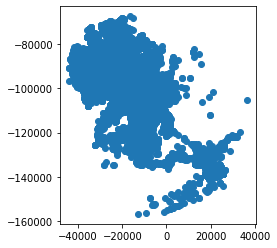

In [56]:
crime_gdf[crime_gdf["relevance"] > 0.8].plot()

## サンプルデータでカーネル密度推定

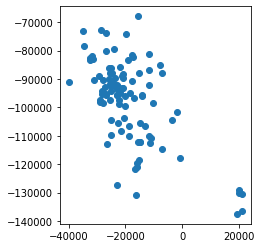

In [57]:
# サンプルを抽出(n=100)
n_sample = 100
sample_gdf = crime_gdf.sample(n_sample)
#display(sample_gdf)
sample_gdf.plot()

In [58]:
# 2次元配列に反感
coord_list= []
for g in sample_gdf["geometry"].values:
    coord_list.append(list(g.coords)[0])

coord_list = np.array(coord_list)
coord_list = np.transpose(coord_list)

print(coord_list.shape)

(2, 100)


In [59]:
# カーネル密度推定
bw_method = "scott"
#bw_method = "silverman"

kde = gaussian_kde(coord_list, bw_method=bw_method)

In [60]:
# 任意のデータを外挿
target_geometry = np.array([(0, 0), (1000, 1000), (-20000, -90000)])
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)
kde.evaluate(target_geometry)

(2, 3)


array([2.09518176e-64, 5.27371056e-67, 1.21104515e-09])

## 全データでカーネル密度推定

In [61]:
# 2次元配列に反感
coord_list= []
for g in crime_gdf["geometry"].values:
    coord_list.append(list(g.coords)[0])

coord_list = np.array(coord_list)
coord_list = np.transpose(coord_list)

print(coord_list.shape)

(2, 39351)


In [62]:
# カーネル密度推定
bw_method = "scott"
#bw_method = "silverman"

kde = gaussian_kde(coord_list, bw_method=bw_method)

In [63]:
# 任意のデータを外挿
target_geometry = np.array([(0, 0), (1000, 1000), (-20000, -90000)])
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)
kde.evaluate(target_geometry)

(2, 3)


array([0.0000000e+00, 0.0000000e+00, 1.9002447e-09])

## ヒートマップの生成

In [64]:
n_split = 100 # 1000x1000に分割
min_x = np.min(coord_list[0])
max_x = np.max(coord_list[0])
min_y = np.min(coord_list[1])
max_y = np.max(coord_list[1])
x_range = np.linspace(min_x, max_x, n_split)
y_range = np.linspace(min_y, max_y, n_split)

target_geometry = []
for x, y in itertools.product(x_range, y_range):
    target_geometry.append((x, y))

target_geometry = np.array(target_geometry)
target_geometry = np.transpose(target_geometry)
    
print(target_geometry.shape)

(2, 10000)


In [65]:
density_list = kde.evaluate(target_geometry)
print(len(density_list))

10000


In [106]:
log_density_list = np.log(density_list)

mmscaler = MinMaxScaler(feature_range=(0, 1))
log_density_list = log_density_list.reshape(-1, 1)
mmscaler.fit(log_density_list)
alpha = mmscaler.transform(log_density_list)
alpha_list = alpha.reshape(1, -1)[0]
print(alpha_list)

[0.05251544 0.09237738 0.13193312 ... 0.08902227 0.0450516  0.        ]


In [107]:
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)

(2, 10000)


In [108]:
# GeoJSONに変換
geojson = {
    "type": "FeatureCollection",
    "features": []
}

# ポリゴンの1辺の距離
length_x = np.abs(x_range[1] - x_range[0])
length_y = np.abs(y_range[1] - y_range[0])
radius_x = length_x / 2
radius_y = length_y / 2
print(f"length_x={length_x} length_y={length_y}")

features = []
for (x,y),density,alpha in zip(target_geometry, density_list, alpha_list):
    #print(f"{x} {y} {density}")

    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[[x-radius_x,  y-radius_y],[x+radius_x, y-radius_y],[x+radius_x, y+radius_y],[x-radius_x,  y+radius_y],[x-radius_x,  y-radius_y]]],
        },
        "properties": {
            "density": density,
            "alpha": alpha
        }
    }
    
    features.append(feature)
    
geojson["features"] = features
print(geojson["features"][0])

length_x=814.7826140213074 length_y=904.5823187090282


ValueError: too many values to unpack (expected 2)

In [88]:
# GeoJSONファイルを書込
with open("./geojson/crime-density-2020.geojson", "w") as f:
    json.dump(geojson, f, ensure_ascii=False)

In [95]:
density_gdf = gpd.read_file("./geojson/crime-density-2020.geojson")
density_gdf = density_gdf.set_crs(epsg=6675, allow_override=True)
print(len(density_gdf))
display(density_gdf)

10000


,density,alpha,geometry
0,1.498961e-98,0.0,"POLYGON ((-44467.368 -157329.253, -43652.585 -..."
1,8.709786e-95,0.0,"POLYGON ((-44467.368 -156424.671, -43652.585 -..."
2,4.734890e-91,0.0,"POLYGON ((-44467.368 -155520.089, -43652.585 -..."
3,2.067897e-87,0.0,"POLYGON ((-44467.368 -154615.506, -43652.585 -..."
4,7.149516e-84,0.0,"POLYGON ((-44467.368 -153710.924, -43652.585 -..."
...,...,...,...
9995,4.181931e-87,0.0,"POLYGON ((36196.111 -71393.933, 37010.894 -713..."
9996,4.713197e-91,0.0,"POLYGON ((36196.111 -70489.351, 37010.894 -704..."
9997,4.199330e-95,0.0,"POLYGON ((36196.111 -69584.768, 37010.894 -695..."
9998,2.957810e-99,0.0,"POLYGON ((36196.111 -68680.186, 37010.894 -686..."


In [48]:
# 現在のEPSGコード
density_gdf.crs

<Projected CRS: EPSG:6675>
Name: JGD2011 / Japan Plane Rectangular CS VII
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Japan - onshore - Honshu between approximately 136°15'E and 137°45'E - Ishikawa-ken; Toyama-ken; Gifu-ken; Aichi-ken.
- bounds: (136.22, 34.51, 137.84, 37.58)
Coordinate Operation:
- name: Japan Plane Rectangular CS zone VII
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [49]:
# 緯度軽度に変換
density_gdf = density_gdf.to_crs(epsg=4326)
display(density_gdf)

,density,geometry
0,1.498961e-98,"POLYGON ((136.68197 34.58082, 136.69085 34.580..."
1,8.709786e-95,"POLYGON ((136.68192 34.58898, 136.69080 34.589..."
2,4.734890e-91,"POLYGON ((136.68187 34.59713, 136.69076 34.597..."
3,2.067897e-87,"POLYGON ((136.68183 34.60529, 136.69071 34.605..."
4,7.149516e-84,"POLYGON ((136.68178 34.61344, 136.69066 34.613..."
...,...,...
9995,4.181931e-87,"POLYGON ((137.56494 35.35582, 137.57391 35.355..."
9996,4.713197e-91,"POLYGON ((137.56498 35.36397, 137.57395 35.363..."
9997,4.199330e-95,"POLYGON ((137.56502 35.37213, 137.57399 35.372..."
9998,2.957810e-99,"POLYGON ((137.56506 35.38028, 137.57403 35.380..."


In [50]:
# GeoJSONファイルを書込
with open("./geojson/crime-density-mesh-2020.geojson", "w") as f:
    json.dump(geojson, f, ensure_ascii=False)